In [1]:
%pylab inline
import scipy.stats
#import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


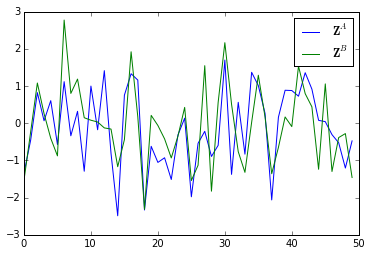

In [2]:
tau = 0.6
C = np.array(((1, tau), (tau, 1)))
mvrv = scipy.stats.multivariate_normal(mean=np.zeros((2,)), cov=C)

n=50
vs = mvrv.rvs(n)
RA, RB = zip(*vs)

RA, RB = np.array(RA), np.array(RB)

plot(RA, label="$\mathbf{Z}^{A}$")
plot(RB, label="$\mathbf{Z}^{B}$")
legend()

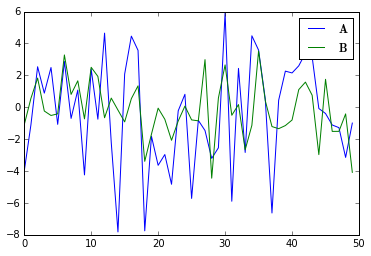

In [3]:
alpha = 3.2
beta = 1.4

sigma2_A = 0.5
sigma2_B = 1.0

A = alpha * RA + np.random.randn(n)*sigma2_A
B = beta * RB+ np.random.randn(n)*sigma2_B
plot(A, label="$\mathbf{A}$")
plot(B, label="$\mathbf{B}$")
legend()


In [4]:
alpha_hat = np.sqrt(np.dot(A, A)/n - sigma2_A)
print alpha_hat

K = tau*alpha_hat/(alpha_hat**2+sigma2_A)
R = alpha_hat**2 * tau**2 / (alpha_hat**2 + sigma2_A)
c = K*A

# RB has conditional dist N(KA, R)
# B has conditional dist N(beta*K*A, beta**2 * R + sigma2_B)

3.28953517163


In [5]:
def lik(beta):
    #m = beta*K*A
    #C = (beta**2 * R + sigma2_B) * np.eye(n)
    #rv = scipy.stats.multivariate_normal(m, C)
    #return rv.logpdf(B)
    c = K*A
    C = beta**2 * R + sigma2_B
    ll = -.5 * (np.dot(B, B) - 2*beta*np.dot(B, K*A) + beta**2 * np.dot(c, c)) / C - n/2.0*np.log(C) -n/2.0*np.log(2*np.pi)
    return ll
    
def dlik_correct(beta):
    c = K*A
    C = beta**2 * R + sigma2_B
    dC_dbeta = 2*beta*R
    num = np.dot(B, B) - 2*beta*np.dot(B, K*A) + beta**2 * np.dot(c, c)
    dnum_dbeta = -2*np.dot(B, K*A) + 2*beta * np.dot(c, c)
    d = -.5 * (dnum_dbeta * C - dC_dbeta*num) / (C**2) - (n*dC_dbeta)/(2.0 *C)
    return d
    
def dlik(beta):
    c = K*A
    C = beta**2 * R + sigma2_B
    dC_dbeta = -beta*R
    num = np.dot(B, B) - 2*beta*np.dot(B, K*A) + beta**2 * np.dot(c, c)
    dnum_dbeta = np.dot(B, K*A) - beta * np.dot(c, c)
    d = (dnum_dbeta * C - dC_dbeta*num)  + (n*dC_dbeta*C)
    return d

def dlik_cubic(beta):
    c = K*A

    aa = n*R**2 
    ab = 2*R*np.dot(B, K*A) - R*np.dot(B, K*A) 
    ac = n*R* sigma2_B - R *np.dot(B, B) + sigma2_B * np.dot(c, c)
    ad = -sigma2_B*np.dot(B, K*A)
    
    return -(beta**3 * aa + beta**2 * ab + beta*ac + ad)
    
    #return t1 + t2 + t3
    
betas = np.linspace(-5, 5.0, 50)
liks = [lik(b) for b in betas]
dliks = [dlik(b) for b in betas]
dliks2 = [dlik_cubic(b) for b in betas]

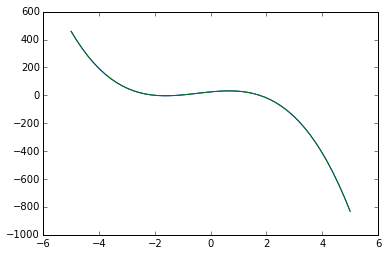

In [6]:
plot(betas, dliks)
plot(betas, dliks2)

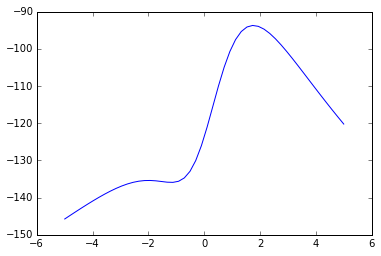

In [7]:
plot(betas, liks)


In [8]:
print lik(2.1829)
print lik(0)

-94.9149505371
-123.650754537


In [9]:

r = scipy.optimize.minimize(lambda x : -lik(x), 1.2)
print r


   status: 0
  success: True
     njev: 8
     nfev: 24
 hess_inv: array([[ 0.06509634]])
      fun: 93.72092005866475
        x: array([ 1.75488622])
  message: 'Optimization terminated successfully.'
      jac: array([  9.53674316e-07])
      nit: 5


In [10]:
def lderiv(beta):
    c = K*A
    nc = np.dot(c, c)
    
    aa = nc - nc*R + n*R**2
    ab = np.dot(B, c)*R
    ac = nc*sigma2_B - np.dot(B, B)*R + n*R*sigma2_B
    ad = -np.dot(B, c) * sigma2_B
    
    r = beta**3 * aa + beta**2 + ab + beta * ac + ad
    denom = (beta**2 * R + sigma2_B)
    return r #/ (denom**2)

ds = [lderiv(b) for b in betas]

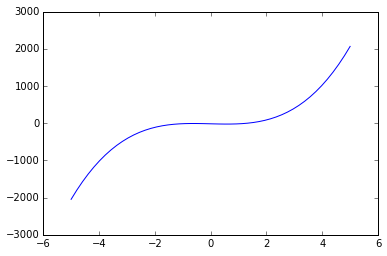

In [11]:
plot(betas, ds)

In [12]:
def soln():
    c = K*A

    aa = n*R**2 
    ab = R*np.dot(B, c)
    ac = n*R* sigma2_B - R *np.dot(B, B) + sigma2_B * np.dot(c, c)
    ad = -sigma2_B*np.dot(B, c)
    
    d0 = ab**2 - 3*aa*ac
    d1 = 2*ab**3-9*aa*ab*ac+27*aa**2*ad
    #d = 18*aa*ab*ac*ad-4*ab**3*ad+ab**2*ac**2-4*aa*ac**3-27*aa**2*ad**2
    #inside = -27*aa**2*d
    
    inside = d1**2 - 4*d0**3
    inside = inside+0j
    
    
        
    C = ((d1 + np.sqrt(inside))/2.0)**(1/3.0)
    
    u1 = (-1+np.sqrt(-3+0j))/2.0
    u2 = (-1-np.sqrt(-3+0j))/2.0
    u = u2
    
    uC = u*C
    print uC + d0/uC
    
    #u=1
    s = -1/(3*aa) * (ab + uC + d0/(uC))
    
    
    
    return s


print soln()



(12.5173473211+2.48689957516e-14j)
(-1.17953094177-1.40022112856e-15j)


In [13]:
def mle_beta(B, c, kappa, sigma2_B):
    
    def lik(beta): 
        C = beta**2 * kappa + sigma2_B
        return -.5 * (np.dot(B, B) - 2*beta*np.dot(B, K*A) + beta**2 * np.dot(c, c)) / C - n/2.0*np.log(C) -n/2.0*np.log(2*np.pi)
    
    aa = n*kappa**2 
    ab = kappa*np.dot(B, c)
    ac = n*kappa* sigma2_B - kappa *np.dot(B, B) + sigma2_B * np.dot(c, c)
    ad = -sigma2_B*np.dot(B, c)
    
    d0 = ab**2 - 3*aa*ac
    d1 = 2*ab**3-9*aa*ab*ac+27*aa**2*ad
    #d = 18*aa*ab*ac*ad-4*ab**3*ad+ab**2*ac**2-4*aa*ac**3-27*aa**2*ad**2
    #inside = -27*aa**2*d
    
    inside = d1**2 - 4*d0**3 + 0j
    C = ((d1 + np.sqrt(inside))/2.0)**(1/3.0)
    
    
    
    u1 = (-1+np.sqrt(-3+0j))/2.0
    u2 = (-1-np.sqrt(-3+0j))/2.0
    us = (1, u1, u2)
    
    bs = [float(np.real(-1/(3*aa) * (ab + u*C + d0/(u*C)))) for u in us]
    print kappa, d0, d1, bs
    
    #print bs
    bs = (np.min(bs), np.max(bs))
    bs = [b for b in bs if b > 0] + [0,]
    liks = [lik(b) for b in bs]
    i = np.argmax(liks)
    return bs[i], liks[i]

    best_b = None
    best_lik = -np.inf
    for b in bs:
        blik = lik(b)
        if blik > best_lik:
            best_lik = blik
            best_b = b        
    if best_b is None:
        best_b = 0
        best_lik = lik(0)
    return best_b, best_lik
        

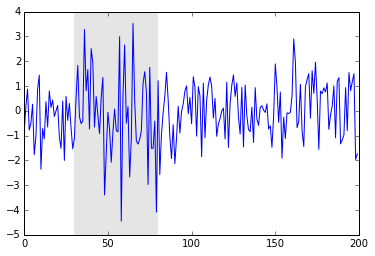

In [14]:
N=200
S = np.random.randn(N) * sigma2_B
S[30:80] = B
plot(S)
plt.axvspan(30, 80, color='gray', alpha=0.2, lw=0)

In [15]:
rv = scipy.stats.norm(0, scale=np.sqrt(sigma2_B))
ll_S = np.sum(rv.logpdf(S))
lls = np.zeros((N-50,))
for i in range(N-50):
    bb = S[i:i+50]
    ll_bb = np.sum(rv.logpdf(bb))
    print i
    b, lik = mle_beta(bb, K*A, 1-R, sigma2_B)
    lls[i] = ll_S - ll_bb + lik
    

0
0.655899597019 54.2352569648 -24140.3561952 [-0.25826279271735236, 0.457100280857321, -0.2582627927173522]
1
0.655899597019 35.2084861647 -68347.5336219 [-0.3793465627051782, 0.5910524685183628, -0.3793465627051781]
2
0.655899597019 73.7424137422 -100947.092002 [-0.4560115124735866, 0.6631107727242505, -0.4560115124735864]
3
0.655899597019 197.21256684 -30340.1330633 [-0.31558766544539485, 0.5547569814921856, -0.31558766544539474]
4
0.655899597019 204.299379426 -37651.2962982 [-0.33814020786422255, 0.5813454810631894, -0.3381402078642223]
5
0.655899597019 190.751818091 21180.6437064 [-0.5161387626188234, 0.28471747450960144, 0.28471747450960144]
6
0.655899597019 224.51490298 -62266.0599983 [-0.40322349462890494, 0.6489922043435689, -0.4032234946289048]
7
0.655899597019 115.288012 36077.3984415 [-0.5360479976545827, 0.3128589830317469, 0.3128589830317469]
8
0.655899597019 444.809318849 -11614.6596031 [-0.4901687106027389, 0.6140906108712119, -0.1544065426943525]
9
0.655899597019 1283.

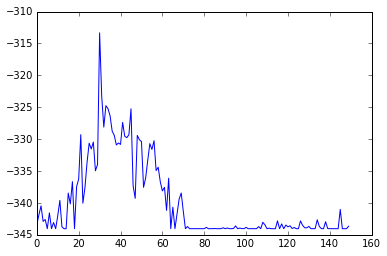

In [16]:
plot(lls)

In [17]:
aux="""
double model_lik(double beta, double kappa, double sigma2_B, double norm2B, double Bc, double norm2c, int nvalid) {
    double C = beta*beta*kappa + sigma2_B;
    double d = log(6.28318530718 * C);
    return -.5 * (norm2B - 2*beta*Bc + beta*beta * norm2c) / C - .5*nvalid*d;
}

double iid_lp(blitz::Array<double,1> S, blitz::Array<int,1> mask, int k, int n, double sigma2_B) {
    double lp = 0;
    double c = -.5*log(6.28318530718 * sigma2_B);
    for(int i=k; i < k+n; ++i) {
       if (mask(i)) continue;
       lp += -.5 * (S(i)*S(i)/sigma2_B) + c;
    }
    return lp;
}

double model_lp(blitz::Array<double,1> S, blitz::Array<int,1> mask, 
                blitz::Array<double,1> c, int k, int n, 
                double kappa, double sigma2_B) {
    /*
    return the log odds of the correlation model for a latent signal c of length n, beginning at time k in S.
    That is, we return
    log(S | latent signal starts at time k) - log (S | no latent signal, everything explained as noise)
    using a maximum likelihood estimate of the scale parameter for the latent signal. 
    */
                
    double norm2B = 0;
    double Bc = 0;
    double norm2c = 0;
    int nvalid = 0;
    for(int i=k; i < k+n; ++i) {
       if (mask(i)) continue;
       norm2B += S(i)*S(i);
       Bc += S(i)*c(i-k);
       norm2c += c(i-k)*c(i-k);
       nvalid += 1;
    }    

    double aa = n*kappa*kappa; 
    double ab = kappa*Bc;
    double ac = n*kappa* sigma2_B - kappa *norm2B + sigma2_B * norm2c;
    double ad = -sigma2_B*Bc;
    
    double d0 = ab*ab - 3*aa*ac;
    double d1 = 2*ab*ab*ab-9*aa*ab*ac+27*aa*aa*ad;

    
    double _Complex inside = d1*d1 - 4*d0*d0*d0 + 0*I;
    double _Complex C = cpow((d1 + csqrt(inside))/2.0, 1/3.0);
    
    
    double _Complex u1 = (-1+sqrt(3.0)*I)/2.0;
    double _Complex u2 = (-1-sqrt(3.0)*I)/2.0;
    double _Complex u3 = 1;
    double b1 = creal(-1/(3*aa) * (ab + u1*C + d0/(u1*C)));
    double b2 = creal(-1/(3*aa) * (ab + u2*C + d0/(u2*C)));
    double b3 = creal(-1/(3*aa) * (ab + u3*C + d0/(u3*C)));
    
    
    double base_lp = iid_lp(S, mask, k, n, sigma2_B);
    
    double best_b = 0;
    double best_lik = 0; // corresponding to beta=0
    double lik;
    if (b1 > 0) {
        lik = model_lik(b1, kappa, sigma2_B, norm2B, Bc, norm2c, nvalid) - base_lp;
        if (lik > best_lik) {
           best_lik = lik;
           best_b = b1;
        }
    }
    if (b2 > 0) {
        lik = model_lik(b2, kappa, sigma2_B, norm2B, Bc, norm2c, nvalid) - base_lp;
        if (lik > best_lik) {
           best_lik = lik;
           best_b = b2;
        }
    }
    if (b3 > 0) {
        lik = model_lik(b3, kappa, sigma2_B, norm2B, Bc, norm2c, nvalid) - base_lp;
        if (lik > best_lik) {
           best_lik = lik;
           best_b = b3;
        }
    }
    printf("%d %f %f %f %f %f\\n", k, creal(inside), b1, b2, b3, best_lik);

    return best_lik;

}


"""


code="""
double baselp = iid_lp(S, mask, 0, N, sigma2_B);
for(int k=0; k < N-n; ++k) {  
    result(k) = baselp + model_lp(S, mask, c, k, n, kappa, sigma2_B);
}
"""

import scipy.weave as weave
from scipy.weave import converters
N = len(S)
result = np.zeros((N-50,))
mask = np.zeros((N,), dtype=np.int32)
c = K*A
kappa = 1-R 
weave.inline(code,['S', 'mask', 'c', 'N', 'n', 'kappa', 'sigma2_B', 'result',],type_converters = converters.blitz,
             verbose=2,compiler='gcc', support_code=aux, headers=["<math.h>","<complex.h>"],)

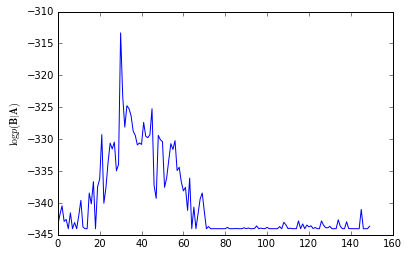

In [18]:
plot(result)
plt.ylabel("$\log p(\mathbf{B} | \mathbf{A})$")

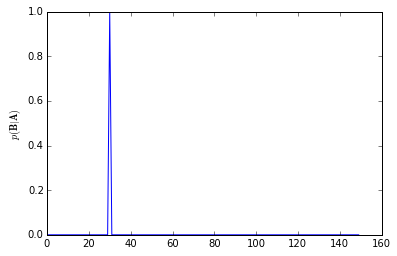

In [19]:
plot(np.exp(result-np.max(result)))
plt.ylabel("$p(\mathbf{B} | \mathbf{A})$")

In [20]:
from sigvisa.signals.xc import my_xc
r = my_xc(A, S)

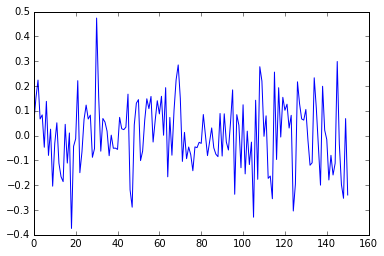

In [21]:
plot(r)